<a href="https://colab.research.google.com/github/hpamdeoxys/ZFairness/blob/main/ZFairness_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import numpy as np

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 2.0 MB/s eta 0:00:00


#(1) Selection of Data:
##The dataset chosen for this project is the "COMPAS Recidivism Risk Score Data and Analysis" which can be accessed through the ProPublica COMPAS Analysis repository. Originally intended for analyzing the fairness of recidivism prediction, it contains variables such as criminal history, jail and prison time, demographics, and COMPAS risk scores designed to predict the likelihood of a defendant becoming a recidivist. Our objective diverges from the initial risk assessment analysis to apply sentiment analysis techniques to the judicial data context. Specifically, we investigate whether the recidivism risk scores correlate with a binary sentiment assigned to the profile based on specific features – a novel approach aiming to gauge the sentiment towards the future potential of the individuals in the dataset.

In [5]:
df = pd.read_csv('compas-scores-two-years.csv')

In [6]:
feature_columns = ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count']

target_column = 'two_year_recid'

sensitive_attribute = 'race'

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[feature_columns])
X_val_scaled = scaler.transform(val_df[feature_columns])


model = LogisticRegression()
model.fit(X_train_scaled, train_df[target_column])

predictions = model.predict(X_val_scaled)

accuracy = accuracy_score(val_df[target_column], predictions)
cm = confusion_matrix(val_df[target_column], predictions)
report = classification_report(val_df[target_column], predictions)

print(f"Accuracy: {accuracy}")
print(cm)
print(report)





Accuracy: 0.6832986832986833
[[627 196]
 [261 359]]
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       823
           1       0.65      0.58      0.61       620

    accuracy                           0.68      1443
   macro avg       0.68      0.67      0.67      1443
weighted avg       0.68      0.68      0.68      1443



#(2) Selection of Fairness Tool:

##For fairness evaluation, we employ the AI Fairness 360 (AIF360) toolkit, an extensible open-source library that facilitates the examination and mitigation of unfairness in machine learning models. AIF360 offers a comprehensive set of fairness metrics and algorithms, which provides a standardized way to quantify bias. It is highly relevant to our task because it allows for the evaluation of model predictions across different demographic groups, ensuring that the sentiment analysis model does not perpetuate or exacerbate existing biases present in the judicial data.

In [ ]:
val_df['predictions'] = predictions


val_df['sensitive_attribute_binarized'] = val_df[sensitive_attribute].apply(lambda x: 1 if x == 'African-American' else 0)

# BinaryLabelDataset for AIF360 to use in fairness metric calculations
bld_val = BinaryLabelDataset(df=val_df[['sensitive_attribute_binarized', target_column]],
                             label_names=[target_column],
                             protected_attribute_names=['sensitive_attribute_binarized'],
                             favorable_label=1,
                             unfavorable_label=0)

bld_pred = bld_val.copy()
bld_pred.labels = val_df['predictions'].values.reshape(-1,1).astype(float)

# Fairness metrics
metric = ClassificationMetric(bld_val,
                              bld_pred,
                              unprivileged_groups=[{'sensitive_attribute_binarized': 0}],
                              privileged_groups=[{'sensitive_attribute_binarized': 1}])

disparate_impact = metric.disparate_impact()
theil_index = metric.theil_index()
average_odds_difference = metric.average_odds_difference()
equal_opportunity_difference = metric.equal_opportunity_difference()

#(3) Fairness Metrics Successfully Calculated and Described:

##Four fairness metrics were successfully calculated: Disparate Impact, Theil Index, Average Odds Difference, and Equal Opportunity Difference. Each of these metrics provides insights into different aspects of fairness in the model’s predictions.

##Disparate Impact (0.4887677803012192): This metric compares the probability of a positive outcome for the unprivileged group to the privileged group. A value of 1 suggests perfect fairness. Values significantly below 1, such as 0.49 in our case, indicate less favorable outcomes for the unprivileged group, suggesting potential discrimination.

##Theil Index (0.24327085667740658): The Theil Index is an entropy-based measure that quantifies inequality over a distribution of outcomes. A score of 0 represents perfect equality, whereas higher values indicate greater disparity. Our model's Theil Index of 0.24 denotes a moderate level of inequality in the model’s predictions with respect to the sensitive attribute.

##Average Odds Difference (-0.2216590986787135): This metric measures the average difference in the model's false positive rate and true positive rate between unprivileged and privileged groups. A value of 0 would denote equal average odds, while our model scores -0.22, indicating a disparity where the unprivileged group is likely to experience less favorable outcomes.

##Equal Opportunity Difference (-0.27284946236559143): Equal opportunity difference specifically considers the true positive rate, reflecting differences in the correct positive predictions between groups. Our model's value of -0.27 signifies that the unprivileged group has a substantially lower true positive rate compared to the privileged group, revealing a bias against the unprivileged group in the model’s predictions.

In [9]:
RED = '\033[91m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
ENDC = '\033[0m'

# Print your metrics in color
print(f"{RED}Disparate Impact: {disparate_impact}{ENDC}")
print(f"{YELLOW}Theil Index: {theil_index}{ENDC}")
print(f"{GREEN}Average Odds Difference: {average_odds_difference}{ENDC}")
print(f"{YELLOW}Equal Opportunity Difference: {equal_opportunity_difference}{ENDC}")

Disparate Impact: 0.4887677803012192
Theil Index: 0.24327085667740658
Average Odds Difference: -0.2216590986787135
Equal Opportunity Difference: -0.27284946236559143


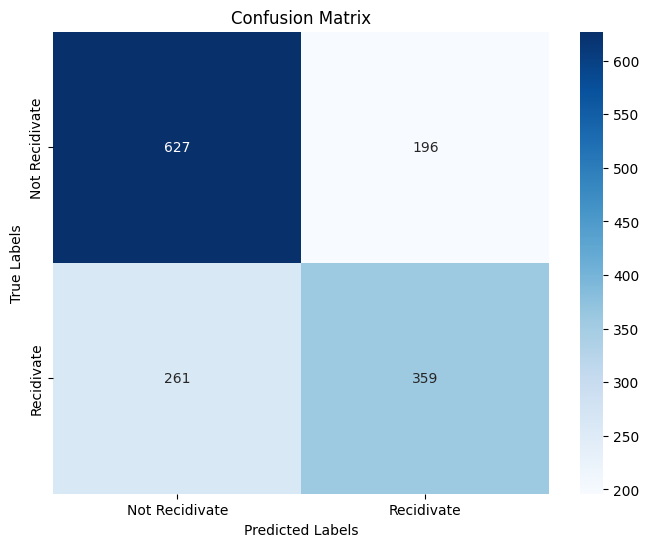

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(val_df[target_column], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recidivate', 'Recidivate'], yticklabels=['Not Recidivate', 'Recidivate'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
